In [1]:
import pickle
import random
from sklearn.utils import shuffle
from urllib.request import urlretrieve
from tqdm import tqdm
from zipfile import ZipFile
import os
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# Image libraries for image processing
import matplotlib.image as mpimg
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline


/home/xilinx/.conda/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:

'''
    Function to convert a RGB image to grayscale image
'''
def rgb2gray(img):
    gray = 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]
    return gray

'''
    Function to get probabilities for all classes, where index in array is class and value at index is probability.
    
    @Arguments
        tensor_op: Output of classification session, having list of probabilities at index as class number.
        total_images_in_set: total number of images classified in 'tensor_op'
        top_n: how many classifications with more probability to choose from the set.
    @Return
        'top_n' classes having highest probabilities as a list containing tuples having class and probability pairs.
'''
def zipProbabilityWithClass(tensor_op, total_images_in_set, top_n):
    tpf_p_l = [None]*total_images_in_set
    for i in range(total_images_in_set):
        tpf_p = []
        tpf_d = {}
        pb = tensor_op[i][0]
        for p in range(len(pb)):
            tpf_p.append(pb[p])
            tpf_d[pb[p]] = p 
        tpf_p.sort(reverse=True)
        #print(tpf_p)
        tpf_p_l[i] = []
        itm_l = []
        for j in range(top_n):
            tpf_p_l[i].append(tpf_d[tpf_p[j]])
            itm_l.append(tpf_p[j])
        tpf_p_l[i] = list(zip(tpf_p_l[i], itm_l))
    return tpf_p_l

'''
    Read the labels from the input file name 'class_file'.
'''
def getClassesFromFile(class_file):
    file = open(class_file, 'r')
    txt = file.read().split('\n')[1:]
    file.close()
    signs = []
    for line in txt:
        signs.append(line.split(',')[-1])
    return signs

'''
    Function to prepare images for training.
    Preparation is done as follows:
        > Convert to grayscale(32x32)
        > normalize the image using formula pixel = (pixel - 128)/128
        > Change shape to 32x32x1
    Output structure of set is same as input.
'''
def prepareImageSet(image_set, label_set):
    #convert to grayscale
    image_set = [((rgb2gray(img)-128)/128).reshape((32,32,1)) for img in image_set]
    return image_set, label_set

'''
    Read the images from 'image_dir' having names in list 'image_names' and prepare a set which
    would be used for prediction.
    Returns two sets, one normal and one grayscale.
'''
def prepareSetWithNewImages(image_dir, image_names):
    test_images = []
    test_images_g = []
    for i in range(len(image_names)):
        img = Image.open(image_dir+image_names[i])
        resized_img = img.resize((32, 32))
        resized_arr = np.asarray(resized_img)
        test_images.append(resized_arr)
        resized_arr = ((rgb2gray(resized_arr)-128)/128).reshape((32,32,1))
        test_images_g.append(resized_arr)
    return test_images, test_images_g

'''
    Extracts data from zip file
    src: name of the source zip file
    tgt_dir: target directory, where contents need to be extracted
'''
def unzip(src, tgt_dir):
    zip_ref = ZipFile(src, 'r')
    zip_ref.extractall(tgt_dir)
    zip_ref.close()

In [3]:
# Load pickled data
training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

#check if files are present, if not then download
file = "traffic-signs-data.zip"
url = "https://s3.amazonaws.com/video.udacity-data.com/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip"
if not (os.path.isfile(file) or os.path.isfile('train.p')):
    print('Downloading', file, '...')
    urlretrieve(url, file)
    print('Download Finished')
unzip(file, "./")
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Load signs from file "signames.csv"
signs = getClassesFromFile("signames.csv")

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
--------------------------
Some random images from the training set.


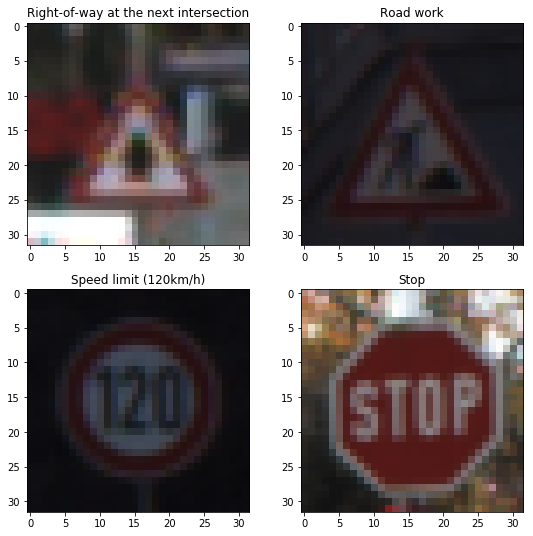

--------------------------

Some images for "33:Turn right ahead"


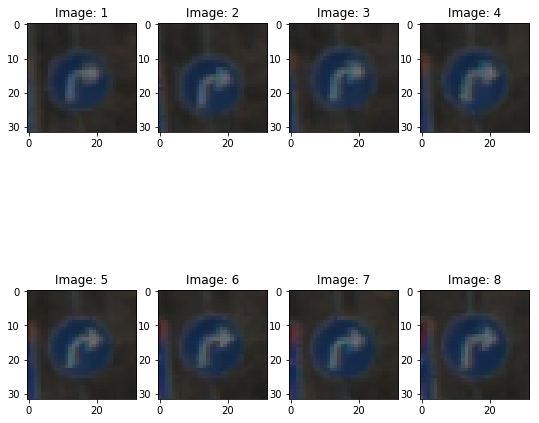

--------------------------
Distribution on images among classes


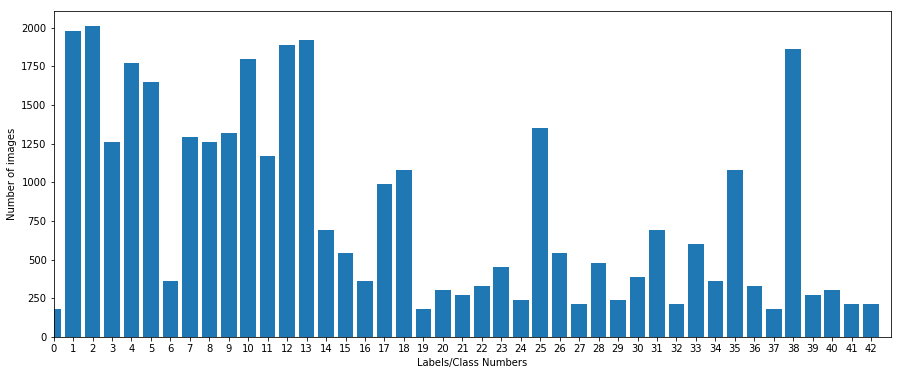

In [4]:
%matplotlib inline
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = np.copy(y_train)
n_classes = len(set(n_classes))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# Display some images from the training set.
print("--------------------------")
print("Some random images from the training set.")

fig = plt.figure(figsize=(9,9))
for i in range(4):
    sf = fig.add_subplot(2, 2, i+1)
    ri = random.randint(0, len(X_train))
    plt.imshow(X_train[ri])
    sf.set_title(signs[y_train[ri]])
plt.show()

print("--------------------------")
print()
sign_no = 33 #random.randint(0, len(signs))
print('Some images for "'+str(sign_no)+':'+signs[sign_no]+'"')
img = []
i=0
while True:
    if y_train[i] == sign_no:
        img.append(X_train[i])
    if len(img) == 8:
        break
    i+=1

fig1 = plt.figure(figsize=(9,9))
for i in range(8):
    sf = fig1.add_subplot(2, 4, i+1)
    plt.imshow(img[i])
    sf.set_title("Image: "+str(i+1))
plt.show()
print("--------------------------")
print("Distribution on images among classes")
dist = [0]*n_classes
ty = list(y_train)
for i in range(n_classes):
    dist[i] = ty.count(i)

fig2 = plt.figure(figsize=(15,6))
plt.xlabel("Labels/Class Numbers")
plt.ylabel("Number of images")
plt.axis([0, n_classes, 0, max(dist)+100])
plt.bar(list(range(n_classes)), dist)
plt.xticks(list(range(n_classes)), list(range(n_classes)))
plt.show()

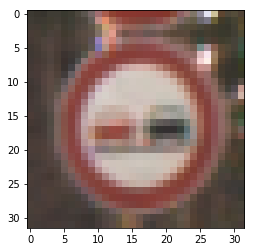

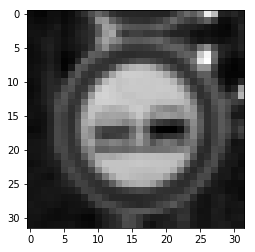

In [5]:
plt.imshow(X_train[11212])
plt.show()
plt.imshow(rgb2gray(X_train[11212]), cmap="gray")
plt.show()
# function usage: image_set, label_set = prepareImageSet(image_set, label_set)
# it converts the input dataset to grayscale
X_train, y_train = prepareImageSet(X_train, y_train)
X_valid, y_valid = prepareImageSet(X_valid, y_valid)
X_test, y_test = prepareImageSet(X_test, y_test)

In [6]:
layer1 = None
layer2 = None

def model(x):
    global layer1
    global layer2
    print(x.shape)
    mu = 0
    sigma = 0.1
    keep_prob = 0.9
    weights = {
        "cnv1": tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 24), mean = mu, stddev = sigma), name='cnv1'),
        "cnv2": tf.Variable(tf.truncated_normal(shape=(5, 5, 24, 68), mean = mu, stddev = sigma), name='cnv2'),
        "cnv3": tf.Variable(tf.truncated_normal(shape=(7*7*68, 976), mean = mu, stddev = sigma), name='fcn1'),
        "cnv4": tf.Variable(tf.truncated_normal(shape=(976, 172), mean = mu, stddev = sigma), name='fcn2'),
        "cnv5": tf.Variable(tf.truncated_normal(shape=(172, n_classes), mean = mu, stddev = sigma, name='fcn3'))
    }
    biases = {
        'bcv1': tf.Variable(tf.zeros([24]), name='bcv1'),
        'bcv2': tf.Variable(tf.zeros([68]), name='bcv2'),
        'bcv3': tf.Variable(tf.zeros([976]), name='bcv3'),
        'bcv4': tf.Variable(tf.zeros([172]), name='bcv4'),
        'bcv5': tf.Variable(tf.zeros([n_classes]), name='bcv5')
    }
    # Layer 1: Convolutional. Input=32x32x1, Output = 28x28x24
    layer1 = tf.nn.conv2d(x, weights['cnv1'], strides=[1,1,1,1], padding="VALID") + biases['bcv1']
    layer = tf.nn.relu(layer1)
    #Pooling, Input = 28x28x24, Output = 14x14x24
    layer = tf.nn.max_pool(layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    
    # Layer 2: Convolutional. Input=14x14x24, Output = 14x14x68
    layer2 = tf.nn.conv2d(layer, weights['cnv2'], strides=[1,1,1,1], padding="SAME") + biases['bcv2']
    layer = tf.nn.relu(layer2)
    #Pooling, Input = 14x14x68, Output = 7x7x68
    layer = tf.nn.max_pool(layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    
    #flatten the image, output = 3332
    layer = flatten(layer)
    layer = tf.nn.dropout(layer, keep_prob) # keep_prob = 0.9
    
    #Layer 3: Fully connected Input = 3332, Output = 976
    layer = tf.add(tf.matmul(layer, weights['cnv3']), biases['bcv3'])
    layer = tf.nn.relu(layer)
    
    #Layer 4: Fully connected Input = 976, Output = 172
    layer = tf.add(tf.matmul(layer, weights['cnv4']), biases['bcv4'])
    layer = tf.nn.relu(layer)
    layer = tf.nn.dropout(layer, keep_prob)
    
    #Layer 5: Fully connected Input = 172, Output = 43
    layer = tf.add(tf.matmul(layer, weights['cnv5']), biases['bcv5'])
    logits = tf.nn.relu(layer)
    return logits

In [7]:
# Evaluate the model against the input set.
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [8]:
x = tf.placeholder(tf.float32, (None, 32,32,1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.0000361
MAX_EPOCHS = 200
BATCH_SIZE = 128

logits = model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Softmax probabilities
sfm_pbs = tf.nn.softmax(logits)

# Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

(?, 32, 32, 1)


In [9]:
#Initializations for the plot
# display live chart in notebook
'''
%matplotlib notebook
ac_list = [None]*(MAX_EPOCHS+1)    # list of accuracies achieved in each epoch while training

plt.ion()       # enable interactive plotting
fig = plt.figure(figsize=(13,6))
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.axis([1, MAX_EPOCHS, 0, 1.05])
plt.grid(color='g', linestyle='-')
plt.yticks(np.arange(0, 1.05, 0.05))
plt.xticks(np.arange(0, MAX_EPOCHS+1, 10))
line1, = plt.plot(list(range(MAX_EPOCHS+1)), ac_list, 'b-') 
line1.set_marker(',')
plt.show()

line1.set_ydata(ac_list)
fig.canvas.draw()

#limit gpu memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
#start learning
c_epoch = 0
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print('|>', end='')
    #Train until target is reached
    while True:
        if c_epoch >= MAX_EPOCHS:
            break
        c_epoch += 1
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid).round(4)
        #print("Epoch {} ...".format(c_epoch), "Validation Accuracy = {:.3f}".format(validation_accuracy))
        print('-', end='')
        # Update the plot
        ac_list[c_epoch] = 1-validation_accuracy
        line1.set_ydata(ac_list)
        fig.canvas.draw()
        if validation_accuracy >= 0.925:
            print('<|')
            break
    print('<|')
    training_accuracy = evaluate(X_train, y_train).round(4)
    saver.save(sess, './model')
    print("Model saved")
print("Validation Accuracy:", validation_accuracy)
print("Training Accuracy:", training_accuracy)
'''

'\n%matplotlib notebook\nac_list = [None]*(MAX_EPOCHS+1)    # list of accuracies achieved in each epoch while training\n\nplt.ion()       # enable interactive plotting\nfig = plt.figure(figsize=(13,6))\nplt.xlabel("Epochs")\nplt.ylabel("Error")\nplt.axis([1, MAX_EPOCHS, 0, 1.05])\nplt.grid(color=\'g\', linestyle=\'-\')\nplt.yticks(np.arange(0, 1.05, 0.05))\nplt.xticks(np.arange(0, MAX_EPOCHS+1, 10))\nline1, = plt.plot(list(range(MAX_EPOCHS+1)), ac_list, \'b-\') \nline1.set_marker(\',\')\nplt.show()\n\nline1.set_ydata(ac_list)\nfig.canvas.draw()\n\n#limit gpu memory\ngpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)\n#start learning\nc_epoch = 0\nwith tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:\n    sess.run(tf.global_variables_initializer())\n    num_examples = len(X_train)\n    \n    print("Training...")\n    print(\'|>\', end=\'\')\n    #Train until target is reached\n    while True:\n        if c_epoch >= MAX_EPOCHS:\n            break\n       

In [10]:
with tf.Session() as sess:
    last_check = tf.train.latest_checkpoint('.')
    saver = tf.train.import_meta_graph(last_check+'.meta')
    saver.restore(sess, last_check)

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./model
Test Accuracy = 0.912


INFO:tensorflow:Restoring parameters from ./model


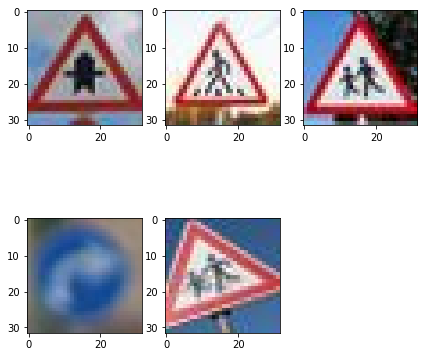

-----------------------


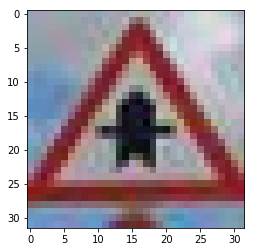

Right-of-way at the next intersection : 1.0
Beware of ice/snow : 3.5465678e-10
Dangerous curve to the right : 3.672121e-12
General caution : 2.4999549e-12
Double curve : 1.1343633e-12
-----------------------


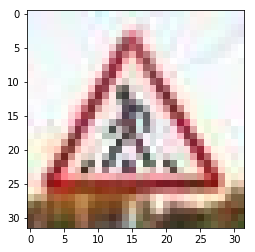

General caution : 0.9766237
Traffic signals : 0.015149269
Dangerous curve to the right : 0.008139563
Pedestrians : 6.2669125e-05
Road work : 2.4301737e-05
-----------------------


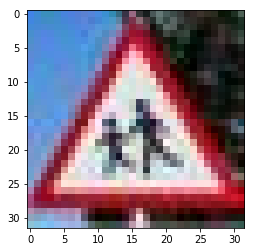

Dangerous curve to the right : 0.9994087
General caution : 0.0005126386
Children crossing : 7.820799e-05
Right-of-way at the next intersection : 3.9872222e-07
Slippery road : 7.4952425e-08
-----------------------


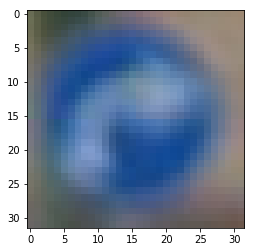

Turn right ahead : 0.9793243
No passing for vehicles over 3.5 metric tons : 0.0070822695
Turn left ahead : 0.0042437855
No passing : 0.003511541
Right-of-way at the next intersection : 0.0014913392
-----------------------


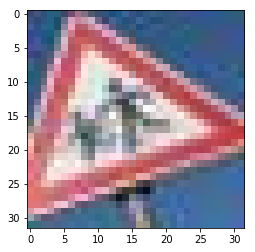

Speed limit (30km/h) : 0.9996686
Right-of-way at the next intersection : 0.00022172586
General caution : 7.372295e-05
Road work : 2.522633e-05
Speed limit (70km/h) : 9.639933e-06
-----------------------


In [11]:
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline

test_img_dir = "./test_images/"
test_img_names = ["img1.jpg", "img2.jpg", "img3.jpg", "img4.jpg", "img5.jpg"]

# test_images are color images and test_images_g are grayscale equivalents
test_images, test_images_g = prepareSetWithNewImages(test_img_dir, test_img_names)
y_new = [11, 27, 28, 33, 28]
fig = plt.figure(figsize=(7,7))
for i in range(5):
    sf = fig.add_subplot(2, 3, i+1)
    plt.imshow(test_images[i])

#restore variable state from saved model and get the softmax probabilities for each image
res_l = [None]*5
with tf.Session() as sess:
    last_check = tf.train.latest_checkpoint('.')
    saver = tf.train.import_meta_graph(last_check+'.meta')
    saver.restore(sess, last_check)
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    #get softmax probabilities
    for i in range(5):
        res_l[i] = sess.run(sfm_pbs, feed_dict={x:test_images_g[i:i+1]})

# get top 5 predictions for each of the images
tpf_p_l = zipProbabilityWithClass(res_l, 5, 5)

#Display votes
fig = plt.figure()
plt.show()
print('-----------------------')
for i in range(5):
    sf = fig.add_subplot(5, 1, i+1)
    plt.imshow(test_images[i])
    plt.show()
    for v in tpf_p_l[i]:
        print(signs[v[0]],":",v[1])
    print('-----------------------')

In [19]:
# Get number of correct predictions
ttl_ni = len(tpf_p_l)
ccl_cnt = 0
for i in range(ttl_ni):
    if tpf_p_l[i][0][0] == y_new[i]:
        ccl_cnt += 1
print("Total number of new images:", ttl_ni)
print("Number of images classified correctly:", ccl_cnt)
print("Accuracy for new images:", (100*ccl_cnt/ttl_ni))

Total number of new images: 5
Number of images classified correctly: 2
Accuracy for new images: 40.0


In [20]:
def np4d_to_list(np_arr):
    ns = np_arr.shape
    nl = []
    for oc in range(ns[3]):
        nl.append(list())
        for ic in range(ns[2]):
            nl[-1].append(list())
            for w in range(ns[1]):
                nl[-1][-1].append(list())
                for h in range(ns[0]):
                    nl[-1][-1][-1].append(np_arr[w][h][ic][oc])
    return nl

def np3d_to_list(np_arr):
    ns = np_arr.shape
    nl = []
    for oc in range(ns[2]):
        nl.append(list())
        for w in range(ns[1]):
            nl[-1].append(list())
            for h in range(ns[0]):
                nl[-1][-1].append(np_arr[w][h][oc])
    return nl

def np1d_to_list(np_arr):
    return np_arr.tolist()

In [21]:

with tf.Session() as sess:
    last_check = tf.train.latest_checkpoint('.')
    #last_check = './lenet'
    #saver = tf.train.import_meta_graph(last_check+'.meta')
    #saver.restore(sess, last_check)
    
    saver.restore(sess, last_check)
    print(last_check)
    print('---------------|---------------|---------------|---------------')
    all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    graph = tf.get_default_graph()
    #w1 = graph.get_tensor_by_name("w1:0")
    cnt = 0
    no_of_layers = 5
    layer_weights_biases = ''
    layers = dict()
    # contains layer meta data
    # layer_no:{type, shape:{output_channels, input_channels, height, width}, weights, biases}
    #wf = open('weights.txt', 'w+')
    
    i = 0
    for weight_name, bias_name in list(zip(['cnv1:0','cnv2:0','fcn1:0','fcn2:0','fcn3:0'],
                                           ['bcv1:0','bcv2:0','bcv3:0','bcv4:0','bcv5:0'])):
        i+=1
        if i > no_of_layers:
            break
        l_weights = sess.run(graph.get_tensor_by_name(weight_name))
        l_bias = sess.run(graph.get_tensor_by_name(bias_name))
        layer_type = weight_name.split(':')[0][:3]
        
        layers[i] = {'type':layer_type,
                     'shape':l_weights.shape,
                     'weights': None,
                     'bias':np1d_to_list(l_bias)}
        print('layer type:', layer_type)
        print(l_weights)
        break
        if layer_type == 'fcn':
            layers[i]['weights'] = np1d_to_list(l_weights)
        else:
            layers[i]['weights'] = np4d_to_list(l_weights)
        
        print('layer:', i, '\n\tweights:', weight_name.split(':')[0], '.. shape:', l_weights.shape)
        print( '\tbiases:', bias_name.split(':')[0], '.. shape:', l_bias.shape)
    
    layer_weights_biases = str(layers)
    #wf.write(layer_weights_biases)
    #wf.close()
    print("logged...")

INFO:tensorflow:Restoring parameters from ./model
./model
---------------|---------------|---------------|---------------
layer type: cnv
[[[[-1.82691887e-01 -3.39439660e-02 -1.23148881e-01 -3.51875462e-02
     8.41171443e-02 -1.65339634e-02 -2.10659400e-01 -2.34591037e-01
     1.90806426e-02 -3.30135636e-02  3.90594788e-02 -1.94332987e-01
    -4.70298827e-02 -1.23451672e-01  1.17190881e-02 -9.33785811e-02
    -8.52509513e-02  1.78427175e-01  4.15616296e-02  1.13537282e-01
     2.04159692e-01 -2.67880321e-01  1.00510746e-01  1.29261509e-01]]

  [[ 6.08261637e-02  1.00202814e-01 -1.85592640e-02  1.26693055e-01
    -1.55553855e-02  7.63652027e-02 -7.98902661e-02 -1.99955329e-01
     3.01312981e-03  1.68076396e-01  6.78561032e-02 -1.02343127e-01
     2.29382105e-02  2.10359588e-01  1.50415570e-01 -4.12174966e-03
     6.84026405e-02  8.11448414e-03  5.07056378e-02  1.98815502e-02
     8.85165185e-02  6.96422830e-02  6.22554347e-02 -1.23340905e-01]]

  [[-2.26891726e-01 -5.38252071e-02  1.0

### Custom DNN Forward pass with loaded weights

In [15]:
# Open weights file and evaluate the dictionary to variable 'layers'
with open('weights.txt', 'r') as wf:
    layer_weights_biases = wf.read()
layers = eval(layer_weights_biases)
# Test
print('First layer type:',layers[1]['type'])

First layer type: cnv


In [16]:
from libdnn import dnn

def fw_model(input_v, layers):
    batch_sz = len(input_v)
    # convolution layer-1
    op_layer1 = dnn.matadd(dnn.conv2d(input_v, filter_mtx=layers[1]['weights'], strides=(1,1), padding='valid'),
                           [layers[1]['bias']]*batch_sz)
    op_layer1 = dnn.relu(op_layer1)
    op_pool_layer1 = dnn.maxpool_2d(op_layer1, kernel_size=2, strides=(2,2), padding='same')
    
    # convolutional layer-2
    op_layer2 = dnn.matadd(dnn.conv2d(op_pool_layer1, filter_mtx=layers[2]['weights'], strides=(1,1), padding='same'),
                           [layers[2]['bias']]*batch_sz)
    op_layer2 = dnn.relu(op_layer2)
    op_pool_layer2 = dnn.maxpool_2d(op_layer2, kernel_size=2, strides=(2,2), padding='same')
    
    # flatten layer
    op_flat_layer2 = dnn.flatten(op_pool_layer2)
    
    # fully connected layer-3
    op_layer3 = dnn.matadd(dnn.matmul(op_flat_layer2, layers[3]['weights']),
                           [layers[3]['bias']]*batch_sz)
    op_layer3 = dnn.relu(op_layer3)
    
    # fully connected layer-4
    op_layer4 = dnn.matadd(dnn.matmul(op_layer3, layers[4]['weights']),
                          [layers[4]['bias']]*batch_sz)
    op_layer4 = dnn.relu(op_layer4)
    
    # fulle conencted layer-5
    op_layer5 = dnn.matadd(dnn.matmul(op_layer4, layers[5]['weights']),
                          [layers[5]['bias']]*batch_sz)
    logits = dnn.relu(op_layer5)
    return logits

(32, 32, 1)


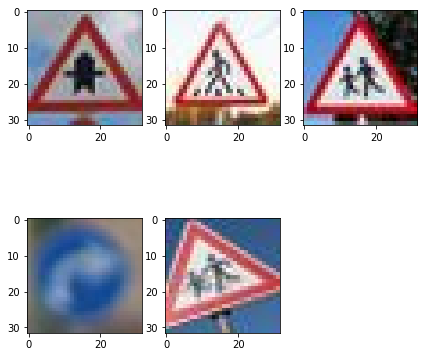

In [17]:
'''print(dnn.matadd([[[[1,2],
                   [2,3]],
                  [[0,1],
                   [2,3]],
                  [[4,5],
                   [6,7]]]], [[1,2,1]]))
'''

fig = plt.figure(figsize=(7,7))
for i in range(5):
    sf = fig.add_subplot(2, 3, i+1)
    plt.imshow(test_images[i])


#restore variable state from saved model and get the softmax probabilities for each image
res_l = [None]*5
#get softmax probabilities
#print(test_images_g[0:1])
print(test_images_g[0:1][0].shape)
#img = np3d_to_list(test_images_g[0:1][0])
#print(img)

In [18]:
#for i in range(1):
#    print("Inference:", i+1)
#    res_l[i] = dnn.softmax(fw_model([np3d_to_list(test_images_g[i:i+1][0])], layers))
#print("Done.")
#print([np3d_to_list(test_images_g[i:i+1][0])])
# get top 5 predictions for each of the images
for i in range(len(res_l)):
    if res_l[i] is not None:
        res_l[i] = res_l[i][0][0]
    res_l[i] = [res_l[i]]
tpf_p_l = zipProbabilityWithClass(res_l, 1, 5)

#Display votes
fig = plt.figure()
plt.show()
print('-----------------------')
for i in range(1):
    sf = fig.add_subplot(1, 1, i+1)
    plt.imshow(test_images[i])
    plt.show()
    for v in tpf_p_l[i]:
        print(signs[v[0]],":",v[1])
    print('-----------------------')

TypeError: object of type 'NoneType' has no len()